In [1]:
# Tutorial 2: Building my own environment

# Building a simple environment to train a QL agent to understand
# the general concepts of building environments suitable for training
# an agent.

In [2]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

In [3]:
style.use ("ggplot")

In [4]:
SIZE = 10
HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 3000
FOOD_REWARD = 25
epsilon = 0.9
EPS_DECAY = 0.9998
SHOW_EVERY = 3000

start_q_table = None # None OR filename (if already done previously)

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_ID = 1
FOOD_ID = 2
ENEMY_ID = 3

d = {1: (255, 175, 0),
     2: (0, 255, 0),
     3: (0, 0, 255)}

In [5]:
class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
    
    def __str__(self):
        return f"{self.x, {self.y}}"
    
    def __sub__(self, other):
        return (self.x - other.x, self.y - other.y)
    
    def action(self, choice):
        if choice == 0: # Move up
            self.move(x = 1, y = 0)
        elif choice == 1: # Move down
            self.move(x = -1, y = 0)
        elif choice == 2: # Move right
            self.move(x = 0, y = 1)
        elif choice == 3: # Move left
            self.move(x = 0, y = -1)
        elif choice == 4: # Move up-right
            self.move(x = 1, y = 1)
        elif choice == 5: # Move up-left
            self.move(x = 1, y = -1)
        elif choice == 6: # Move down-right
            self.move(x = -1, y = 1)
        elif choice == 7: # Move down-left
            self.move(x = -1, y = -1)
    
    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y
    
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
            
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

In [6]:
if start_q_table == None:
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for x2 in range(-SIZE+1, SIZE):
            for y1 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1, x2), (y1, y2))] = [np.random.uniform(-5, 0) for i in range(8)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

on # 0, epsilon: 0.9
3000 ep mean:nan


C:\Users\Toffee\.conda\envs\Reinforcement_Learning\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Toffee\.conda\envs\Reinforcement_Learning\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 3000, epsilon: 0.49390083359356435
3000 ep mean:-1179.7726666666667
on # 6000, epsilon: 0.27104225936046566
3000 ep mean:-706.578
on # 9000, epsilon: 0.14874221981913022
3000 ep mean:-477.8306666666667
on # 12000, epsilon: 0.08162656262136181
3000 ep mean:-286.926
on # 15000, epsilon: 0.044794919246742226
3000 ep mean:-189.44033333333334
on # 18000, epsilon: 0.024582497729691496
3000 ep mean:-152.91166666666666
on # 21000, epsilon: 0.01349035124500733
3000 ep mean:-101.71466666666667
on # 24000, epsilon: 0.0074032174726434705
3000 ep mean:-98.73633333333333


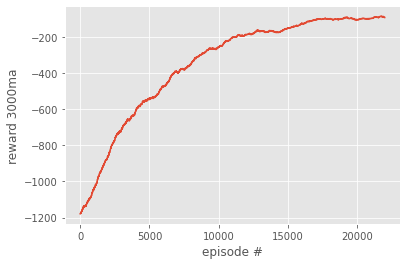

In [7]:
episode_rewards = []
for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if not episode % SHOW_EVERY:
        print (f"on # {episode}, epsilon: {epsilon}")
        print (f"{SHOW_EVERY} ep mean:{np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
        
    episode_reward = 0
    for i in range(200):
        obs = (player-food), (player-enemy)
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,8)
            
        player.action(action)
        
        #enemy.move()
        #food.move()
        
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
            
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1-LEARNING_RATE)*current_q + (LEARNING_RATE*(reward + DISCOUNT*max_future_q))
            
        q_table[obs][action] = new_q
        
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[food.y][food.x] = d[FOOD_ID]
            env[player.y][player.x] = d[PLAYER_ID]
            env[enemy.y][enemy.x] = d[ENEMY_ID]
            
            img = Image.fromarray(env, "RGB")
            img = img.resize((300, 300))
            cv2.imshow("", np.array(img))
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
                if cv2.waitKey(500) & 0xFF == ord("q"):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
            
        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break
                
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY
        
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,)) / SHOW_EVERY, mode="valid")

    
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show
    
with open(f"qtable-{int(time.time())}.pickle","wb") as f:
    pickle.dump(q_table, f)